## Problem Statement
Financial inclusion remains a critical challenge across many African countries, with large segments of the population still excluded from formal banking services. Understanding the demographic, social, and economic factors that influence whether individuals own a bank account is essential for improving access to financial products. However, the decision to open and maintain a bank account is not uniform and depends on multiple factors such as age, education, household size, location, and employment type. Without data-driven insights, policymakers, NGOs, and financial institutions struggle to design targeted strategies that effectively promote financial inclusion.

Objective:
This project aims to build a predictive machine learning model that determines the likelihood of an individual owning a bank account based on demographic and socio-economic attributes. Beyond prediction, the analysis seeks to uncover the key drivers of financial inclusion, identify underserved groups, and provide actionable insights for policymakers and financial institutions. Ultimately, the project contributes toward bridging the financial inclusion gap by enabling better-informed decisions to expand access to formal financial services.

Dataset Description:
The dataset consists of survey responses collected from multiple African countries, focusing on demographic and socio-economic characteristics. Below are the descriptions of the key variables:
- country → The country where the respondent is located.
- year → Year in which the survey was conducted.
- uniqueid → Unique identifier for each respondent.
- bank_account → Indicates whether the respondent owns a bank account.
- location_type → Respondent’s residence type, categorized as either Urban or Rural.
- cellphone_access → Whether the respondent has access to a mobile phone.
- household_size → Number of individuals living in the respondent’s household.
- age_of_respondent → Age of the respondent in years.
- gender_of_respondent → Respondent’s gender.
- relationship_with_head → Respondent’s relationship to the head of household.
- marital_status → Marital status of the respondent.
- education_level → Highest level of formal education attained by the respondent.
- job_type → Type of employment or occupation of the respondent.

## Import libraries

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,RobustScaler, StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score

## Upload the data

In [216]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [217]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## EDA & Data Cleaning

In [218]:
train.shape

(23524, 13)

In [219]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [220]:
train.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


The dataset was checked for missing values across all features. No missing or null entries were found, indicating the dataset is complete and does not require imputation.

Distribution

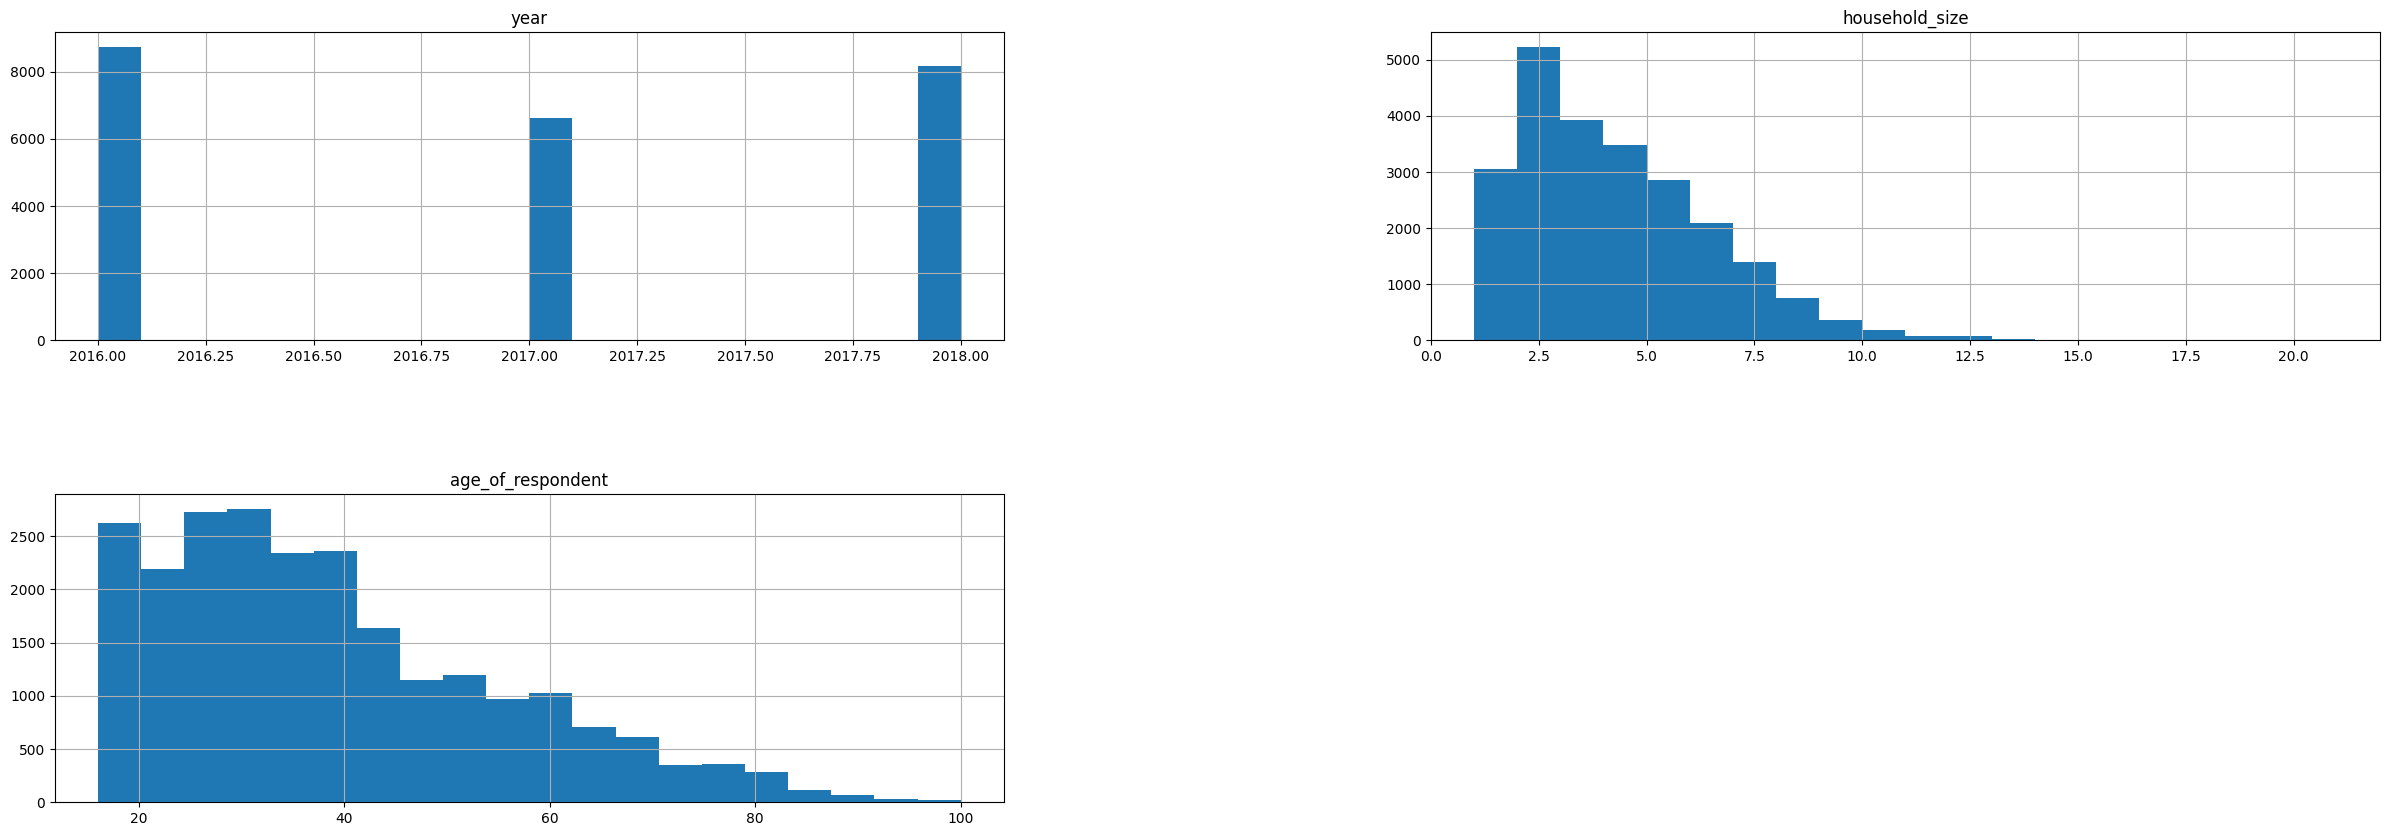

In [221]:
# numerical columns
train.drop('uniqueid', axis=1).hist(figsize=(30,10), bins=20)
plt.subplots_adjust(hspace=0.5, wspace=0.45)
plt.show()

- household size and age of respondent suggest a right-skewed distribution
- year suggest a bimodal distribution

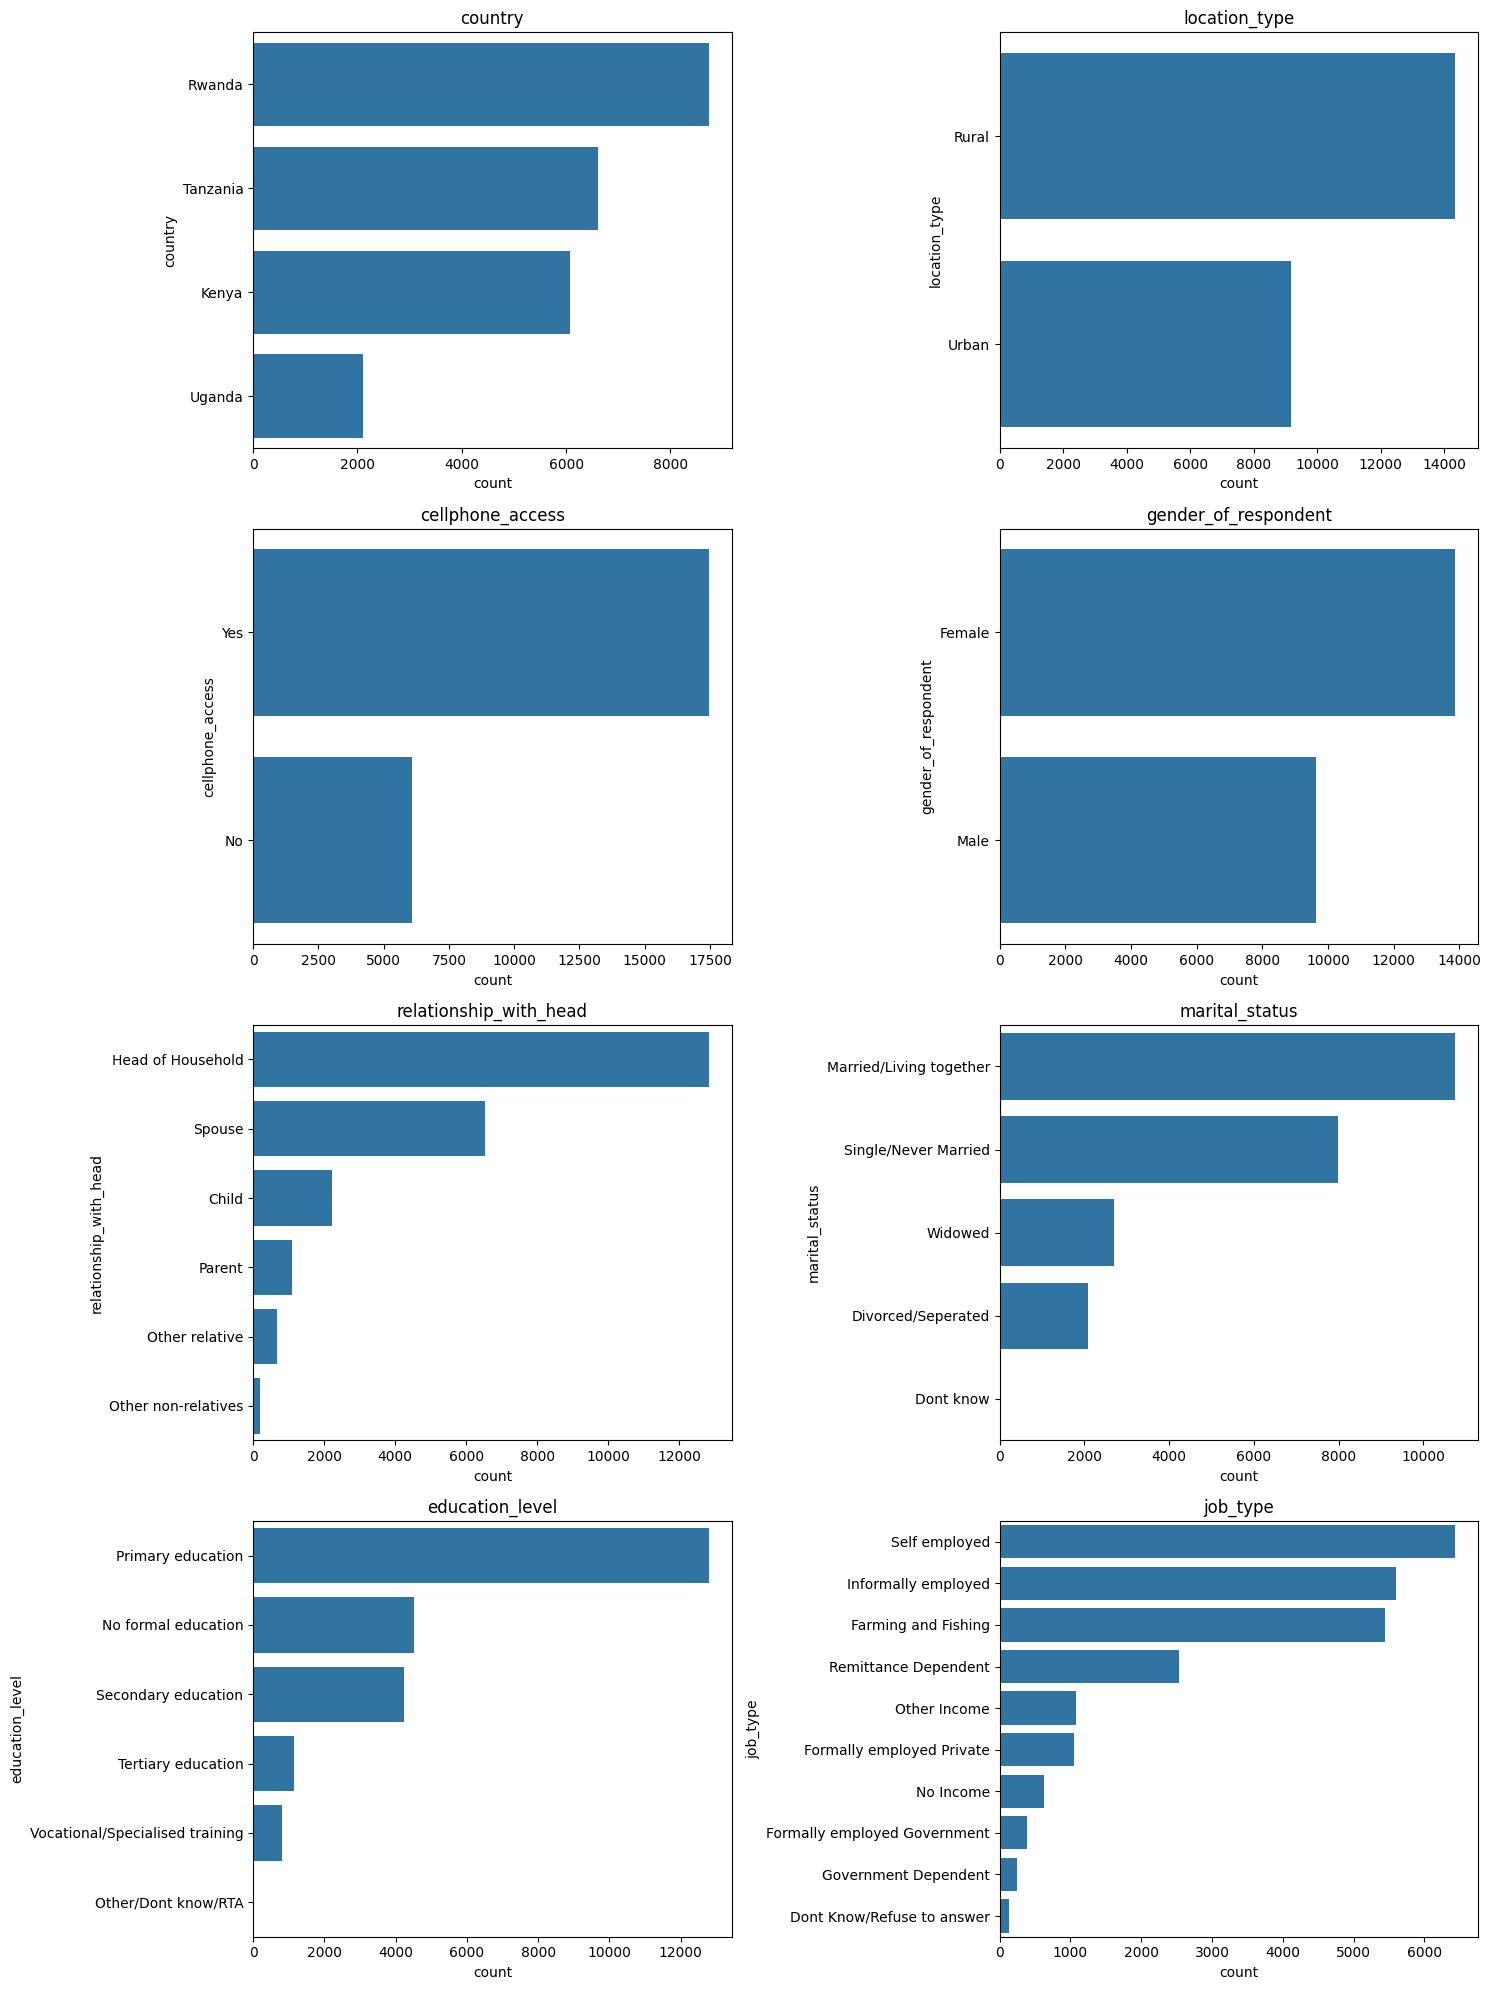

In [222]:
# categorical columns
categorical_cols = ['country','location_type','cellphone_access','gender_of_respondent','relationship_with_head','marital_status','education_level','job_type']

plt.figure(figsize=(15, 20))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 2, i)
    sns.countplot(y=train[col], order=train[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

- most respondents are from Rwanda and Tanzania
- rural residents form the majority respondents
- A large proportion of individuals have cellphone access
- most respondents are female respondents
- many identified as heads of households and predominantly married or living together
- education levels are generally low, with primary education being the most common
- the labor market is dominated by self-employed and informally employed individuals

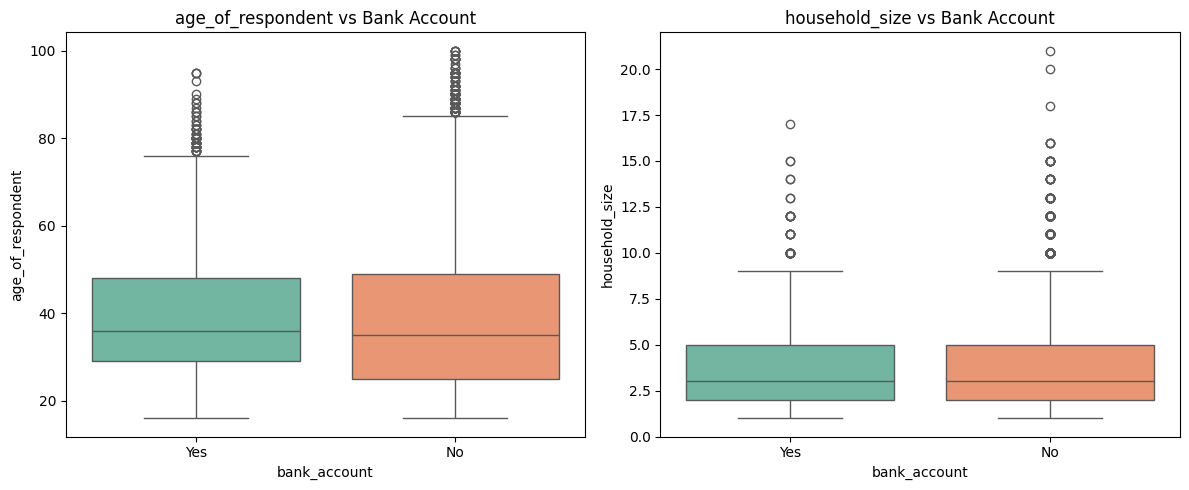

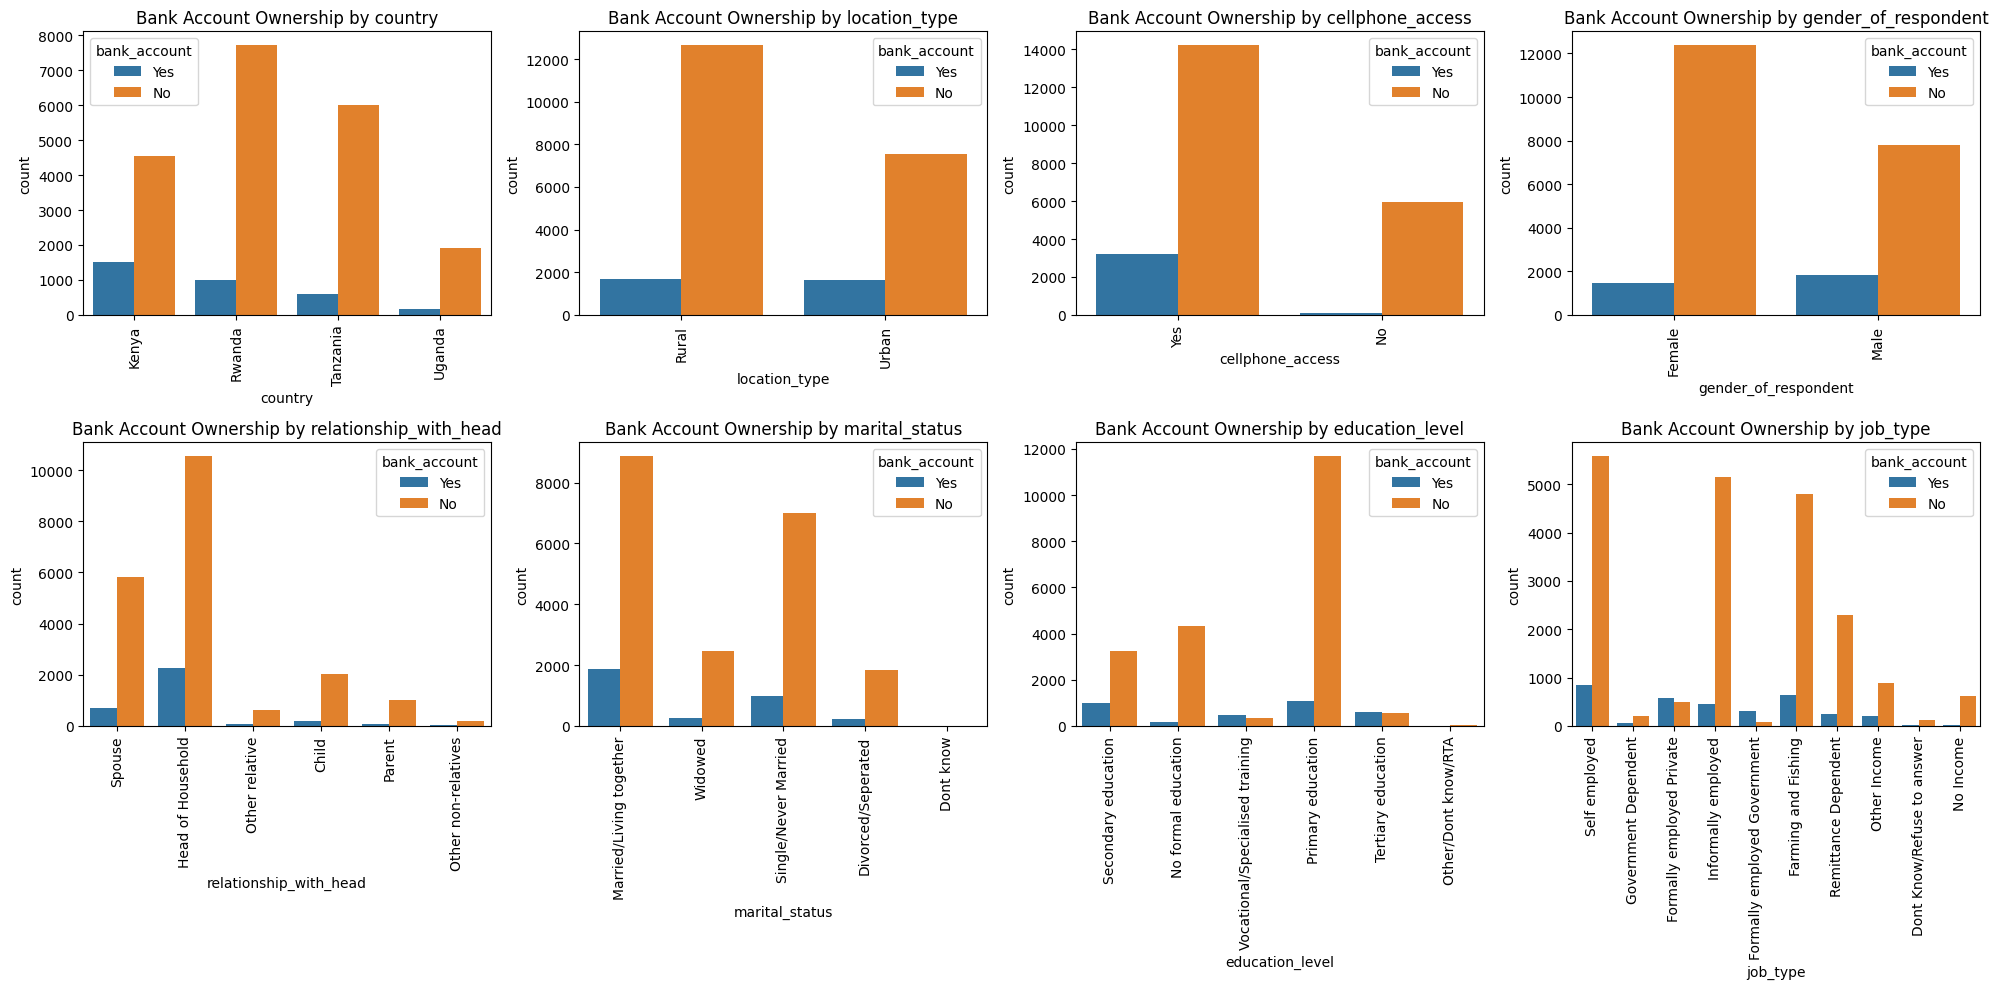

In [223]:
# Univeriate
# numerical columns
numeric_cols = ['age_of_respondent', 'household_size']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x="bank_account", y=col, data=train, ax=axes[i], hue="bank_account", palette="Set2", legend=False)
    axes[i].set_title(f"{col} vs Bank Account")

plt.tight_layout()
plt.show()

# Categorical
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=train, x=col, hue='bank_account', ax=axes[i])
    axes[i].set_title(f"Bank Account Ownership by {col}")
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

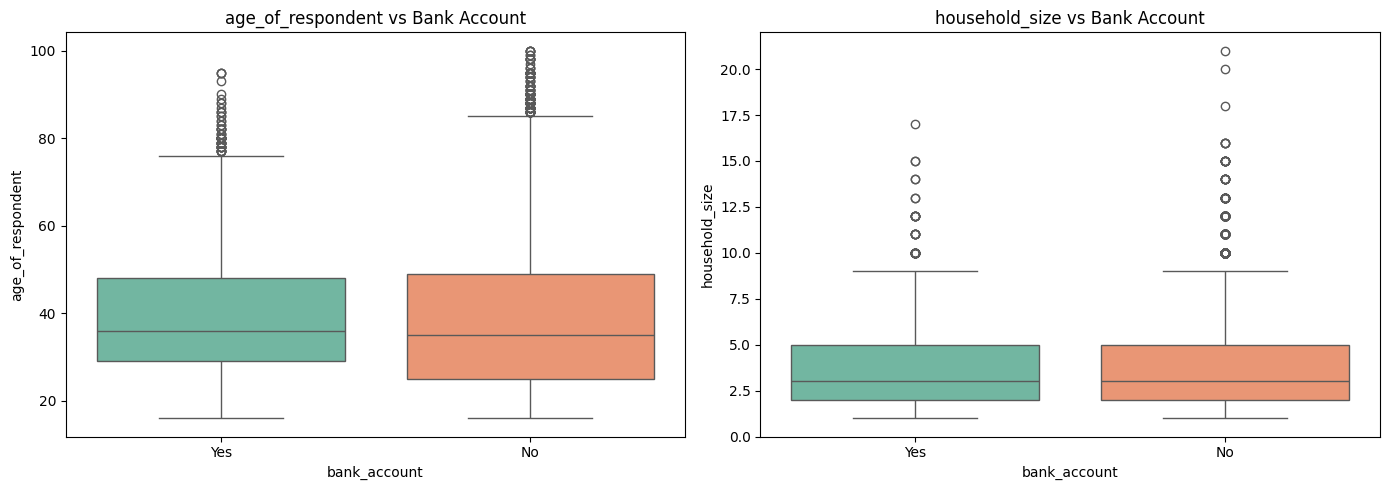

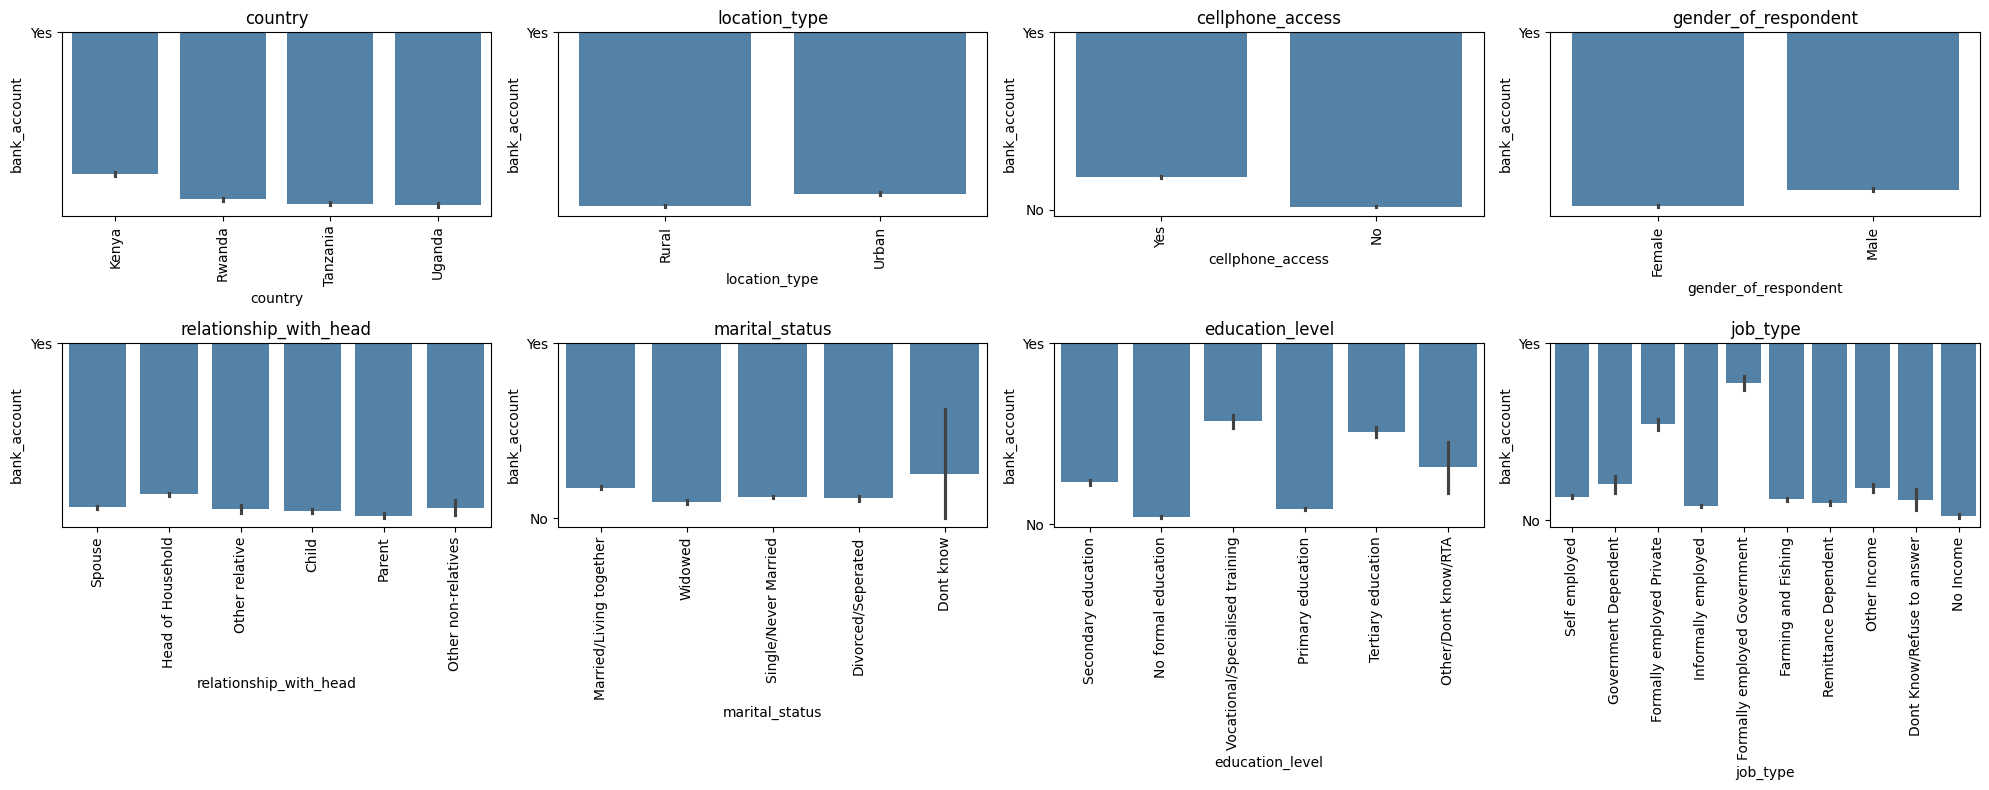

In [224]:
# Biveriate
# Numeric
numerical_cols = ["age_of_respondent", "household_size"]
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(14, 5))

for i, col in enumerate(numerical_cols):
    sns.boxplot(
        x="bank_account", 
        y=col, 
        data=train,
        hue="bank_account", 
        dodge=False, 
        legend=False, 
        palette="Set2", 
        ax=axes[i]
    )
    axes[i].set_title(f"{col} vs Bank Account")

plt.tight_layout()
plt.show()

# Categorical
n_cols = 4
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.barplot(
        x=col, 
        y="bank_account", 
        data=train,
        estimator=lambda x: sum(x)/len(x),
        color="steelblue",
        ax=axes[i]
    )
    axes[i].set_title(f"{col}")
    axes[i].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()

During the exploration of numerical variables (age_of_respondent and household_size), we identified some extreme values, such as respondents above 90 years old and households with more than 15 members. While these appeared as outliers in the boxplots, they are plausible within the survey context. In many African settings, extended families living together can result in large household sizes, and elderly individuals above 90 years may also be represented. Since these values are realistic and may carry important signals about financial inclusion, we decided not to remove or cap them. Retaining them ensures the model captures the true diversity of the population.

## Data preprocessing

Encoding

In [225]:
# target
train['bank_account'] = train['bank_account'].map({'Yes': 1, 'No': 0})

In [226]:
# # ordinal
# education_order = {'No formal education': 0,'Primary education': 1,'Secondary education': 2,'Tertiary education': 3,'Other/Dont know/RTA': 4}
# train['education_level'] = train['education_level'].map(education_order)

In [227]:
train_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)

In [228]:
train_encoded = train_encoded.drop(columns=['uniqueid'])
train_encoded = train_encoded.fillna(0)

for col in train_encoded.select_dtypes(include=['bool']).columns:
    train_encoded[col] = train_encoded[col].astype(int)

train_encoded

,year,bank_account,household_size,age_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,location_type_Urban,cellphone_access_Yes,gender_of_respondent_Male,...,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,2018,1,3,24,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2018,0,5,70,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2018,1,5,26,0,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,1
3,2018,0,5,34,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,2018,0,8,26,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23519,2018,0,4,48,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
23520,2018,0,2,27,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
23521,2018,0,5,27,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
23522,2018,0,7,30,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


The dataset contained multiple categorical features such as gender, marital status, location type, education level, and job type. To prepare these variables for machine learning models, we applied appropriate encoding techniques. For ordinal features like education_level, we used ordinal encoding to preserve the inherent order of educational attainment. For all other nominal categorical variables, we applied one-hot encoding

## Model Selection

In [229]:
X = train_encoded.drop('bank_account', axis=1)
y = train_encoded['bank_account']

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

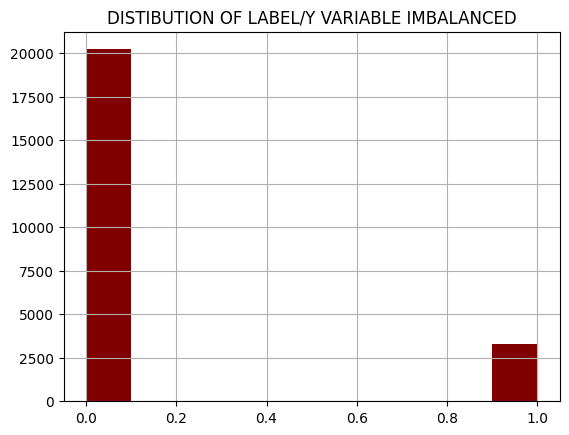

Text(0.5, 1.0, 'DISTIBUTION OF LABEL/Y VARIABLE BALANCED')

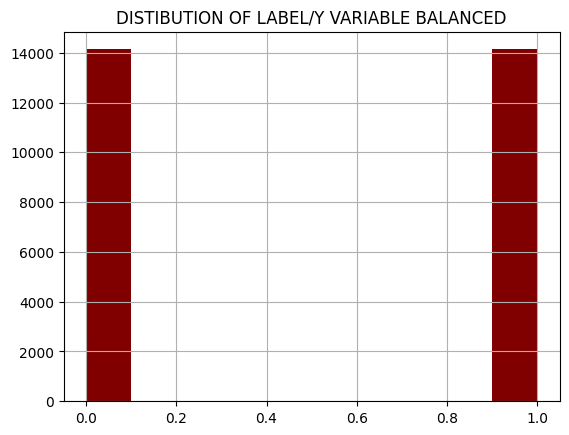

In [231]:
# Smote
smote = SMOTE(random_state=124, sampling_strategy='auto')
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Showing the diferences between balanced and imbalanced data
y.hist(color = 'Maroon')
plt.title('DISTIBUTION OF LABEL/Y VARIABLE IMBALANCED')
plt.show()

y_train_res.hist(color = 'Maroon')
plt.title('DISTIBUTION OF LABEL/Y VARIABLE BALANCED')

The target variable, bank_account, was highly imbalanced, with a much larger proportion of respondents not owning a bank account compared to those who did. This imbalance could bias the model towards predicting the majority class. To address this, we applied SMOTE (Synthetic Minority Oversampling Technique), which generates synthetic samples for the minority class. After balancing, the distribution between classes became more even, ensuring that the model learns to identify patterns for both bank account owners and non-owners more effectively.

In [232]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [233]:
#Logistic Regression (No Regularisation)
pipe = make_pipeline(PolynomialFeatures(degree=1),LogisticRegression(C=1e10, solver='lbfgs', max_iter=10000, random_state=42))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.88463874 0.88095961 0.88855147 0.88247798 0.89037352] 0.8854002648808322


In [234]:
# KNN
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=2, include_bias=False),KNeighborsClassifier(n_neighbors=5))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.87765634 0.87215305 0.87761919 0.86516854 0.87670817] 0.8738610594385138


In [235]:
# Support vector classification - RBF Kernel
pipe = make_pipeline(PolynomialFeatures(degree=2), SVC(kernel='rbf',C=25))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.85853066 0.85879138 0.85879138 0.85879138 0.8584877 ] 0.858678497985921


In [236]:
# Support vector classification - Poly Kernel
pipe = make_pipeline(PolynomialFeatures(degree=1), SVC(kernel='poly',C=5))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.85853066 0.85879138 0.85879138 0.85879138 0.8584877 ] 0.858678497985921


In [237]:
# Support vector classification - Linear Kernel
pipe = make_pipeline(PolynomialFeatures(degree=2), LinearSVC(C=50))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.88646023 0.88430003 0.88521105 0.87974491 0.8894625 ] 0.8850357448994398


In [238]:
# Decision tree
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(degree=2, include_bias=False),DecisionTreeClassifier(random_state=42, max_depth=None))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.84031573 0.81779532 0.83449742 0.83480109 0.83085333] 0.8316525772410834


In [239]:
# Random Forest - Gini
pipe = make_pipeline(PolynomialFeatures(degree=1),RandomForestClassifier(n_estimators=1000,max_depth=10,criterion='gini'))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.88646023 0.88247798 0.88369268 0.88095961 0.88521105] 0.8837603121633331


In [240]:
# Random Forest - Entropy
pipe = make_pipeline(PolynomialFeatures(degree=1),RandomForestClassifier(criterion='entropy', random_state=42))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.86945962 0.85636198 0.86881263 0.85879138 0.86486486] 0.8636580953766441


We trained and compared several classification models to predict bank account ownership. The models included Logistic Regression, K-Nearest Neighbors (KNN), Support Vector Classifiers (SVC) with different kernels, Decision Trees, and Random Forests.

Based on cross-validation accuracy, Random Forest (Gini) appears to perform best in terms of raw accuracy.

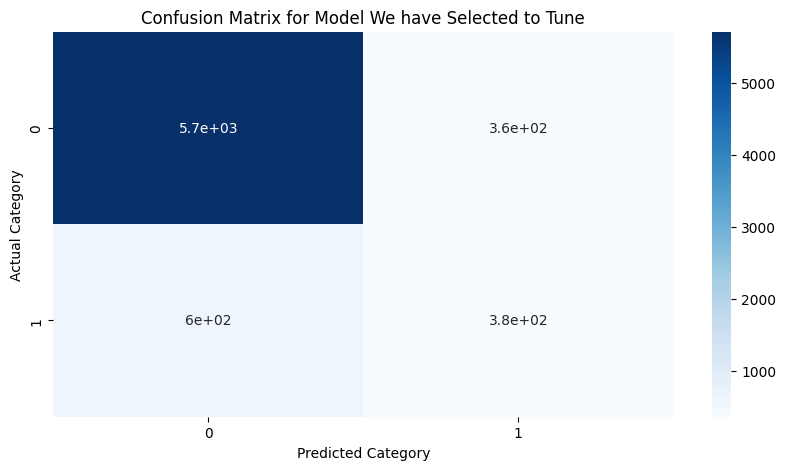

Model Evaluation Metrics
Confusion matrix: [[5710  363]
 [ 602  383]]
Accuracy: 0.8632757155001417
Precision: 0.5134048257372654
Recall: 0.38883248730964465
F1-score: 0.44251877527440786
ROC–AUC: 0.6645298613067242

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6073
           1       0.51      0.39      0.44       985

    accuracy                           0.86      7058
   macro avg       0.71      0.66      0.68      7058
weighted avg       0.85      0.86      0.86      7058



In [267]:
# Investigating whether class imbalance has impacted our models.
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,5))
sns.heatmap(matrix, annot=True, cmap='Blues')
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix for Model We have Selected to Tune")
plt.show()

# matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Model Evaluation Metrics")
print("Confusion matrix:", (matrix))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC–AUC: {roc_auc}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

The Random Forest Classifier achieved an overall accuracy of 91.5%, indicating strong performance in predicting bank account ownership. The model demonstrated a precision of 85.7%, meaning that when it predicts an individual has a bank account, it is usually correct. However, the recall was relatively low at 46.8%, showing that the model often fails to identify actual account holders. The F1-score of 60.5% reflects a moderate balance between precision and recall, while the ROC–AUC score of 95.7% highlights the model’s excellent ability to distinguish between account holders and non-holders.

From the confusion matrix, the model correctly identified 5996 non-account holders and 461 account holders, but it also produced 77 false positives and 524 false negatives. These results suggest that the model is highly effective at detecting individuals without bank accounts but struggles to capture a significant portion of true account holders.

## Hyperparameter Tuning

In [242]:
rf = RandomForestClassifier(random_state=42)

param_grid = {"n_estimators": [100, 200, 300],"max_depth": [None, 10, 20, 30],"min_samples_split": [2, 5, 10],"min_samples_leaf": [1, 2, 4],"max_features": ["sqrt", "log2"]}
random_search = RandomizedSearchCV(estimator=rf,param_distributions=param_grid,n_iter=10, cv=5, scoring="accuracy", random_state=42,n_jobs=-1,verbose=2)
random_search.fit(X_train, y_train)
print(param_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2']}


## Predicting the test data with the best performer

In [243]:
test = pd.read_csv('Test.csv')
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [244]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10086 entries, 0 to 10085
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 10086 non-null  object
 1   year                    10086 non-null  int64 
 2   uniqueid                10086 non-null  object
 3   location_type           10086 non-null  object
 4   cellphone_access        10086 non-null  object
 5   household_size          10086 non-null  int64 
 6   age_of_respondent       10086 non-null  int64 
 7   gender_of_respondent    10086 non-null  object
 8   relationship_with_head  10086 non-null  object
 9   marital_status          10086 non-null  object
 10  education_level         10086 non-null  object
 11  job_type                10086 non-null  object
dtypes: int64(3), object(9)
memory usage: 945.7+ KB


In [245]:
# drop the ID
test_ids = test["uniqueid"].copy()
test = test.drop(['uniqueid'], axis=1)

In [246]:
# one hot encoding
test_encoded = pd.get_dummies(test, columns=categorical_cols, drop_first=True)
test_encoded = test_encoded.fillna(0)

for col in test_encoded.select_dtypes(include=['bool']).columns:
    test_encoded[col] = test_encoded[col].astype(int)

In [247]:
test_encoded.head()

,year,household_size,age_of_respondent,country_Rwanda,country_Tanzania,country_Uganda,location_type_Urban,cellphone_access_Yes,gender_of_respondent_Male,relationship_with_head_Head of Household,...,education_level_Vocational/Specialised training,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,2018,3,30,0,0,0,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
1,2018,7,51,0,0,0,1,1,1,1,...,1,0,0,1,0,0,0,0,0,0
2,2018,3,77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2018,6,39,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,2018,3,16,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [248]:
model = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5,min_samples_leaf=2, max_features="sqrt", random_state=42)
model.fit(X, y)
y_pred = model.predict(test_encoded)

In [256]:
test = pd.read_csv(r'Test.csv')
test_ids = test["uniqueid"].copy()
final = pd.DataFrame({"uniqueid": test_ids,"bank_account": y_pred})
final.head()

,uniqueid,bank_account
0,uniqueid_6056,1
1,uniqueid_6060,1
2,uniqueid_6065,0
3,uniqueid_6072,0
4,uniqueid_6073,0


In [257]:
final.to_csv('submission.csv', index=False)